In [2]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

In [67]:
from mtr.config import cfg, cfg_from_list, cfg_from_yaml_file, log_config_to_file
from mtr.datasets.waymo.waymo_dataset_bc import WaymoDatasetBC as WaymoDataset
# from mtr.datasets.waymo.waymo_dataset import WaymoDataset

from tools.mtr_env import BatchMTREnv
from tools.mtr_inference import MTRInference
from tools.mtr_lightning import MTR_Lightning
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical, Independent

cfg = cfg_from_yaml_file('tools/cfgs/waymo/bc+10_percent_data_atten.yaml', cfg)
dataset = WaymoDataset(cfg.DATA_CONFIG, training=False)
env = BatchMTREnv(1, dataset)


In [192]:
# model = MTR_Lightning(cfg)
# model = MTR_Lightning.load_from_checkpoint('output/bc_atten_0_unfreeze/epoch=31-step=97664.ckpt')
model = MTR_Lightning.load_from_checkpoint('output/bc_atten_2_freeze/epoch=49-step=152600.ckpt')
# model = MTR_Lightning.load_from_checkpoint('output/bc_atten_0_freeze/epoch=31-step=97664.ckpt')
_ = model.cuda()


# Test with dataset

In [50]:
output_mean = model.model.motion_decoder.output_mean
output_std = model.model.motion_decoder.output_std

In [51]:
data = dataset[5]
data_batch = dataset.collate_batch([data])

In [52]:
# model.train()
model.eval()
with torch.no_grad():
    loss, _, output = model.model(data_batch, True)
    center_gt_raw = output['input_dict']['center_gt'][..., :3]
    center_gt = output['input_dict']['center_gt'][...,None, :3].cuda()
    center_gt = (center_gt - output_mean) / output_std


In [53]:

for pred_ctrls, pred_scores in output['pred_list']:
    i=-1
    print(pred_ctrls.shape)
    print(pred_ctrls[i, :, :3])
    print(pred_scores[i, :])
    # print(center_gt[i])
    # print(center_gt_raw[i])

torch.Size([8, 6, 9])
tensor([[-1.0668, -0.0420, -0.0227],
        [-1.0701,  0.2341, -0.0186],
        [-1.0504,  0.1138, -0.0169],
        [-1.0794,  0.4773, -0.0147],
        [-1.0575, -0.2581, -0.0218],
        [-1.0675,  0.1123, -0.0103]], device='cuda:0')
tensor([0.5485, 0.4542, 0.2530, 0.3318, 0.4769, 0.5340], device='cuda:0')


In [54]:

mode = model.model.motion_decoder.build_mode_distribution(pred_ctrls[...,:])
log_p = mode.log_prob(center_gt)
print(log_p)

tensor([[ 1.5533e+00, -2.9550e+01,  3.4729e+00, -2.7673e+01,  6.9667e+00,
         -1.9698e+01],
        [ 3.3826e+00,  3.9135e+00,  3.2395e+00, -2.1563e+00,  1.0286e-01,
          7.3050e+00],
        [ 2.6812e+00, -2.5064e+01,  6.6656e-01, -1.0970e+01,  3.7818e+00,
         -1.2572e+01],
        [ 4.5145e+00, -1.6553e+01,  1.2359e+00, -1.2429e+01,  3.5267e+00,
         -6.3943e+00],
        [ 3.8083e+00, -1.5169e+01,  2.1716e+00, -1.3353e+01,  3.8594e+00,
         -7.1408e+00],
        [ 6.0163e+00, -1.4722e+01,  2.0575e+00, -1.0525e+01,  4.1867e+00,
         -5.0013e+00],
        [-2.2086e+01,  2.6997e+00,  3.5617e-01,  5.4665e-01, -1.3061e+01,
         -8.9581e+00],
        [-2.5025e+02, -4.0042e+02, -2.9438e+00, -1.2063e+02, -3.2170e+01,
         -4.5321e+02]], device='cuda:0')


In [55]:
_, mode, gmm = model.model.motion_decoder.build_gmm_distribution(pred_ctrls, pred_scores)
log_p = -gmm.log_prob(center_gt.squeeze(1))
log_p

tensor([-5.2205, -5.6987, -2.2959, -3.0653, -2.8094, -4.4251, -1.1517,  4.9212],
       device='cuda:0')

In [56]:
mode, mix, gmm, sample = model.sample(data_batch)
print(sample)
print(center_gt_raw)

[[ 5.7608366e-01 -9.5346700e-03  6.4530276e-04]
 [ 1.2381536e-01 -1.6492875e-03 -8.2634706e-03]
 [ 7.9805416e-01 -6.3447002e-03 -2.1295026e-02]
 [ 8.3501506e-01  3.8956083e-02  3.8277246e-02]
 [ 8.3314186e-01 -3.9925769e-02 -2.6768176e-02]
 [ 9.4021761e-01  6.4882897e-02  3.8009536e-02]
 [ 6.3506144e-01  1.6620458e-03 -2.8121591e-02]
 [ 1.3969058e-01  1.3238873e-02  3.5018922e-04]]
tensor([[ 6.4867e-01, -8.8245e-04,  2.2309e-03],
        [ 1.4875e-01,  3.8884e-03,  1.6257e-03],
        [ 6.7763e-01, -3.9613e-02, -2.8359e-02],
        [ 8.1373e-01,  4.8146e-02,  4.0721e-02],
        [ 8.4382e-01, -3.1406e-02, -2.1255e-02],
        [ 9.1865e-01,  4.8350e-02,  3.5570e-02],
        [ 7.1048e-01, -2.6631e-02, -3.7746e-02],
        [-2.8877e-02, -2.6460e-02,  4.2310e-03]])


# Test in simulation

In [332]:
env.reset()

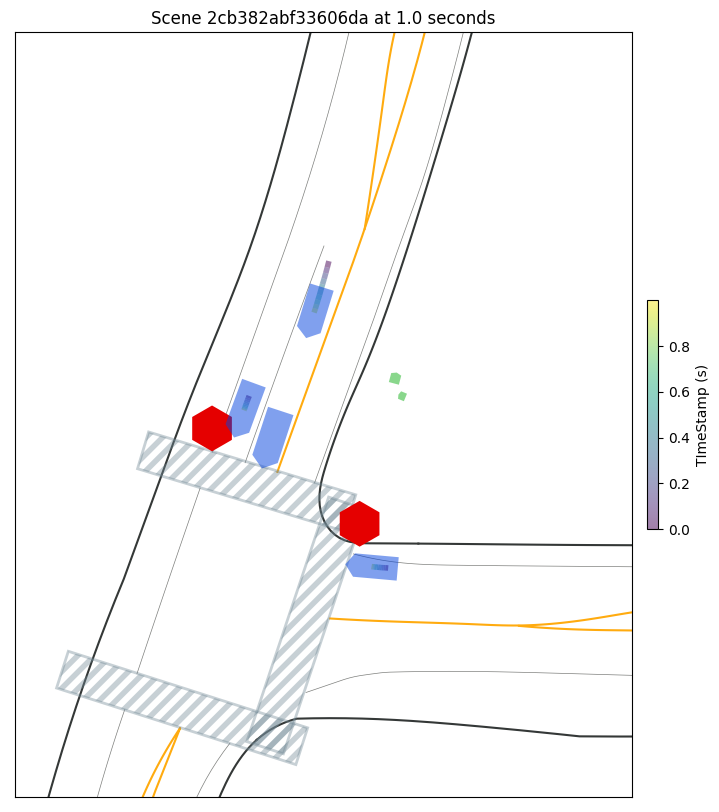

In [333]:
# Reset Time
for temp_env in env.envs_list:
    index = temp_env.index
    temp_env.reset(index)
env.visualize()
current_time_index = env.envs_list[0].current_time_index 

In [342]:
for _ in range(10):
    data_batch_sim = env.batch_sim_data
    action = model.sample(data_batch_sim, -1)[-1]
    _ = env.step(data_batch_sim, action)
_ = env.visualize()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 for _ in range(10):                                                                          │
│   2 │   data_batch_sim = env.batch_sim_data                                                      │
│   3 │   action = model.sample(data_batch_sim, -1)[-1]                                            │
│ ❱ 4 │   _ = env.step(data_batch_sim, action)                                                     │
│   5 _ = env.visualize()                                                                          │
│   6                                                                                              │
│                                                                                                  │
│ /home/zixuzhang/Documents/Git/MTR/tools/mtr_env.py:130 in step                                   │
│                                                                                                  │
│   127 │   │   for i, env in enumerate(self.envs_list):                                           │
│   128 │   │   │   env_mask = data['batch_env_idx'] == i                                          │
│   129 │   │   │   rel_se2_i = rel_se2[env_mask]                                                  │
│ ❱ 130 │   │   │   reset_bool[i] = env.step(rel_se2_i)                                            │
│   131 │   │   return reset_bool                                                                  │
│   132                                                                                            │
│   133 class MTREnv:                                                                              │
│                                                                                                  │
│ /home/zixuzhang/Documents/Git/MTR/tools/mtr_env.py:222 in step                                   │
│                                                                                                  │
│   219 │                                                                                          │
│   220 │   def step(self, rel_se2: np.ndarray):                                                   │
│   221 │   │   self.step_gt()                                                                     │
│ ❱ 222 │   │   self.step_control(rel_se2)                                                         │
│   223 │   │   self.current_time_index += 1                                                       │
│   224 │   │                                                                                      │
│   225 │   │   # self.scene_data = self.extract_scene_data()                                      │
│                                                                                                  │
│ /home/zixuzhang/Documents/Git/MTR/tools/mtr_env.py:250 in step_control                           │
│                                                                                                  │
│   247 │   │   T_next =np.einsum('...ij,...jk->...ik', T_cur, T_rel)                              │
│   248 │   │                                                                                      │
│   249 │   │   x_next, y_next, theta_next = self.SE2_to_state(T_next)                             │
│ ❱ 250 │   │   self.obj_trajs_sim[self.track_index_to_predict, self.current_time_index + 1, 0]    │
│   251 │   │   self.obj_trajs_sim[self.track_index_to_predict, self.current_time_index + 1, 1]    │
│   252 │   │                                                                                      │
│   253 │   │   self.obj_trajs_sim[self.track_index_to_predict, self.current_time_index + 1, 2]    │
╰────────────────────────────────────────────────────────────